In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import numpy as np

# Charger les fichiers .npy
all_images = np.load('/content/drive/MyDrive/Pipeline/Pipeline/pipeline_images.npy')
predictions = np.load('/content/drive/MyDrive/Pipeline/Pipeline/pipeline_predections.npy')


In [21]:
import glob
import os
import matplotlib.pylab as plt
import cv2
import time
import tensorflow as tf
from tensorflow import keras
import numpy as np
from google.colab import drive

# Function to shuffle two arrays in unison
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# Data preparation
x_data = all_images
orientations = predictions[:, 0].reshape(-1, 1)
orientations = np.abs(orientations)
orientations[orientations > 5] = 5

signs = predictions[:, 1].reshape(-1, 1)
signs[signs == -1] = 0
signs = signs.astype(int)

# Combine orientations and signs for shuffling
y_combined = np.concatenate((orientations, signs), axis=1)

# Shuffle data
x_data_shuffled, y_combined_shuffled = shuffle_in_unison(x_data, y_combined)

# Split data into train and test
Xtrain = x_data_shuffled[:800]
Xtest = x_data_shuffled[800:]

Ytrain_orientation = y_combined_shuffled[:800, 0].reshape(-1, 1)  # Orientation labels
Ytest_orientation = y_combined_shuffled[800:, 0].reshape(-1, 1)

Ytrain_sign = y_combined_shuffled[:800, 1]  # Sign labels
Ytest_sign = y_combined_shuffled[800:, 1]

# Check shapes
print("Xtrain shape:", Xtrain.shape)
print("Ytrain_orientation shape:", Ytrain_orientation.shape)
print("Ytrain_sign shape:", Ytrain_sign.shape)


Xtrain shape: (800, 228, 308, 3)
Ytrain_orientation shape: (800, 1)
Ytrain_sign shape: (800,)


In [22]:
import tensorflow as tf


In [1]:
!pip install --upgrade keras


In [23]:
# Model for rotations
model_rotation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_rotation.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                       loss=tf.keras.losses.MeanSquaredError(),
                       metrics=['mae'])

batch_size = 32
epochs = 50
history = model_rotation.fit(Xtrain, Ytrain_orientation,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(Xtest, Ytest_orientation))

# Evaluate model
score_orientation = model_rotation.evaluate(Xtest, Ytest_orientation, verbose=0)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 58.9273 - mae: 4.9173 - val_loss: 11.3862 - val_mae: 3.1998
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 2.6755 - mae: 1.1855 - val_loss: 6.2780 - val_mae: 2.4493
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 2.5576 - mae: 1.0869 - val_loss: 4.5381 - val_mae: 2.1043
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 2.7796 - mae: 1.1655 - val_loss: 4.3160 - val_mae: 2.0530
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 1.9627 - mae: 1.0142 - val_loss: 4.7818 - val_mae: 2.1575
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 1.9767 - mae: 1.0479 - val_loss: 5.2261 - val_mae: 2.2422
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 1.6832 - mae: 0.9606 - val_loss: 6.3829 - val_mae: 2.4358
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.1373 - mae: 0.7406 - val_loss: 4.8833 - val_mae: 2.1592
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 1.

In [24]:
# Function to visualize training evolution
def Training_evolution(history):
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model Rotation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Rotation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    Training_evolution(history)

model_rotation.save("model_rotation.keras")

In [25]:
# Prepare data for signs
x_data_shuffled, y_data_shuffled = shuffle_in_unison(x_data, signs)
Xtrain = x_data_shuffled[:800]
Xtest = x_data_shuffled[800:]
Ytrain_sign = y_data_shuffled[:800]
Ytest_sign = y_data_shuffled[800:]

# Model for signs
model_sign = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_sign.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['accuracy'])

batch_size = 16
epochs = 10
history = model_sign.fit(Xtrain, Ytrain_sign,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(Xtest, Ytest_sign))

# Evaluate model for signs
score_sign = model_sign.evaluate(Xtest, Ytest_sign, verbose=0)

# Save the model for signs
model_sign.save("model_signs.keras")


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5330 - loss: 0.8929 - val_accuracy: 0.6891 - val_loss: 0.6305
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6527 - loss: 0.6162 - val_accuracy: 0.7115 - val_loss: 0.4961
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7051 - loss: 0.5166 - val_accuracy: 0.7917 - val_loss: 0.5246
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7892 - loss: 0.4348 - val_accuracy: 0.8942 - val_loss: 0.3035
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8975 - loss: 0.2654 - val_accuracy: 0.9038 - val_loss: 0.2392
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8870 - loss: 0.3240 - val_accuracy: 0.8590 - val_loss: 0.2820
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8713 - loss: 0.2688 - val_accuracy: 0.9359 - val_loss: 0.2058
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8795 - loss: 0.2420 - val_accuracy: 0.9199 - v

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 9.6017 - orientation_loss: 8.7512 - orientation_mae: 2.3362 - sign_accuracy: 0.5220 - sign_loss: 0.8505 - val_loss: 8.8338 - val_orientation_loss: 8.2749 - val_orientation_mae: 2.7643 - val_sign_accuracy: 0.6923 - val_sign_loss: 0.5985
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 2.8824 - orientation_loss: 2.2435 - orientation_mae: 1.0956 - sign_accuracy: 0.6447 - sign_loss: 0.6390 - val_loss: 6.4298 - val_orientation_loss: 5.8546 - val_orientation_mae: 2.3676 - val_sign_accuracy: 0.6891 - val_sign_loss: 0.5975
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 3.0314 - orientation_loss: 2.4021 - orientation_mae: 1.0803 - sign_accuracy: 0.6540 - sign_loss: 0.6293 - val_loss: 5.9963 - val_orientation_loss: 5.4378 - val_orientation_mae: 2.2889 - val_sign_accuracy: 0.6923 - val_sign_loss: 0.5767
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 2.6609 - orientation_loss: 2.0466 - orientation_mae: 1.

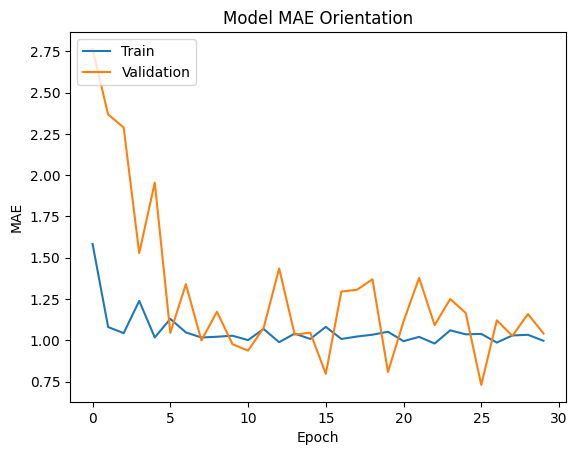

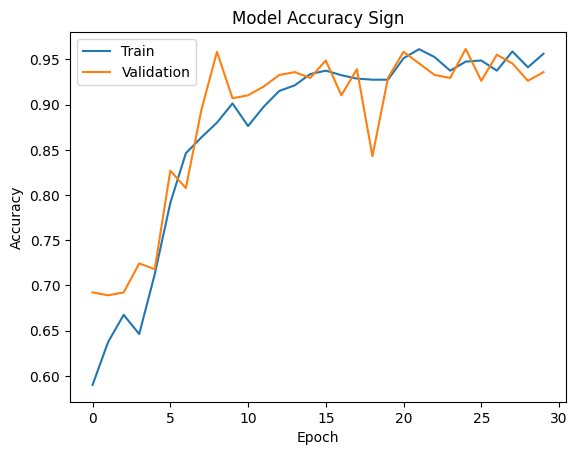

In [30]:
# Define the hybrid model
def build_model():
    input_layer = keras.layers.Input((228, 308, 3))
    x = tf.keras.layers.Rescaling(1./255)(input_layer)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    orientation_output = tf.keras.layers.Dense(1, name='orientation')(x)

    y = tf.keras.layers.Rescaling(1./255)(input_layer)
    y = tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Conv2D(64, 3, activation='relu')(y)
    y = tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Conv2D(32, 3, activation='relu')(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(32, activation='relu')(y)

    sign_output = tf.keras.layers.Dense(1, name='sign', activation='sigmoid')(y)

    model = tf.keras.Model(inputs=input_layer, outputs=[orientation_output, sign_output])
    return model

hybrid_model = build_model()
optimizer = tf.keras.optimizers.Adam(1e-3)

# Compile hybrid model with appropriate loss functions
hybrid_model.compile(optimizer=optimizer,
                     loss={'orientation': tf.keras.losses.MeanSquaredError(),
                           'sign': tf.keras.losses.BinaryCrossentropy()},
                     metrics={'orientation': 'mae', 'sign': 'accuracy'})

batch_size = 16
epochs = 30
history = hybrid_model.fit(Xtrain, {'orientation': Ytrain_orientation, 'sign': Ytrain_sign},
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(Xtest, {'orientation': Ytest_orientation, 'sign': Ytest_sign}))

# Evaluate the hybrid model
score_hybrid_model = hybrid_model.evaluate(Xtest, {'orientation': Ytest_orientation, 'sign': Ytest_sign}, verbose=0)

# Function to visualize training evolution of hybrid model
def Training_evolution(history):
    # Plot MAE for Orientation
    plt.plot(history.history['orientation_mae'])
    plt.plot(history.history['val_orientation_mae'])
    plt.title('Model MAE Orientation')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()



    # Plot Sign Accuracy
    plt.plot(history.history['sign_accuracy'])
    plt.plot(history.history['val_sign_accuracy'])
    plt.title('Model Accuracy Sign')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


# Call the function to visualize training evolution
Training_evolution(history)

# Save the model
hybrid_model.save("hybrid_model.keras")



In [31]:
results_df = pd.DataFrame({
    'Epoch': np.arange(1, epochs + 1),
    'Orientation MAE Train': history.history['orientation_mae'],
    'Orientation MAE Validation': history.history['val_orientation_mae'],
    'Sign Accuracy Train': history.history['sign_accuracy'],
    'Sign Accuracy Validation': history.history['val_sign_accuracy']
})

# Sauvegarder le tableau dans un fichier CSV
results_df.to_csv('metrics_comparative.csv', index=False)
print("Tableau comparatif des métriques sauvegardé sous 'metrics_comparative.csv'.")

Tableau comparatif des métriques sauvegardé sous 'metrics_comparative.csv'.


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 19.7413 - orientation_loss: 18.8606 - orientation_mae: 2.9572 - sign_accuracy: 0.5561 - sign_loss: 0.8808 - val_loss: 11.2779 - val_orientation_loss: 10.7217 - val_orientation_mae: 3.1058 - val_sign_accuracy: 0.6891 - val_sign_loss: 0.6013
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 2.9007 - orientation_loss: 2.2793 - orientation_mae: 1.0838 - sign_accuracy: 0.6558 - sign_loss: 0.6215 - val_loss: 10.0275 - val_orientation_loss: 9.4828 - val_orientation_mae: 2.9382 - val_sign_accuracy: 0.6987 - val_sign_loss: 0.5840
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 2.6951 - orientation_loss: 2.0926 - orientation_mae: 0.9649 - sign_accuracy: 0.6565 - sign_loss: 0.6025 - val_loss: 9.6216 - val_orientation_loss: 9.1241 - val_orientation_mae: 2.8881 - val_sign_accuracy: 0.7212 - val_sign_loss: 0.5348
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 3.0111 - orientation_loss: 2.4466 - orientation_m

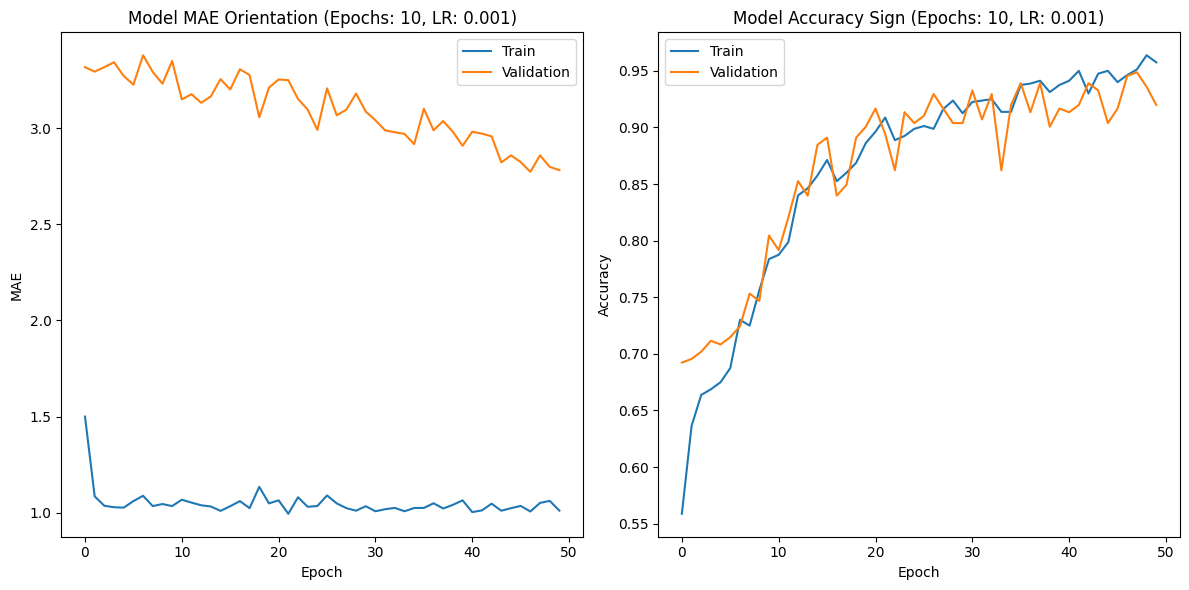

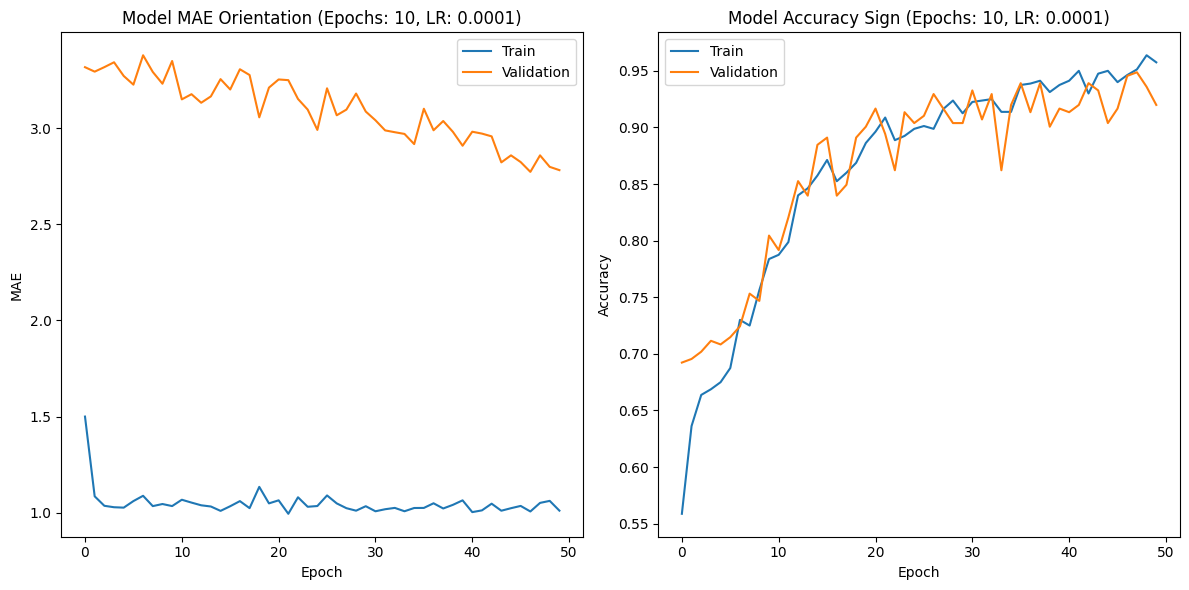

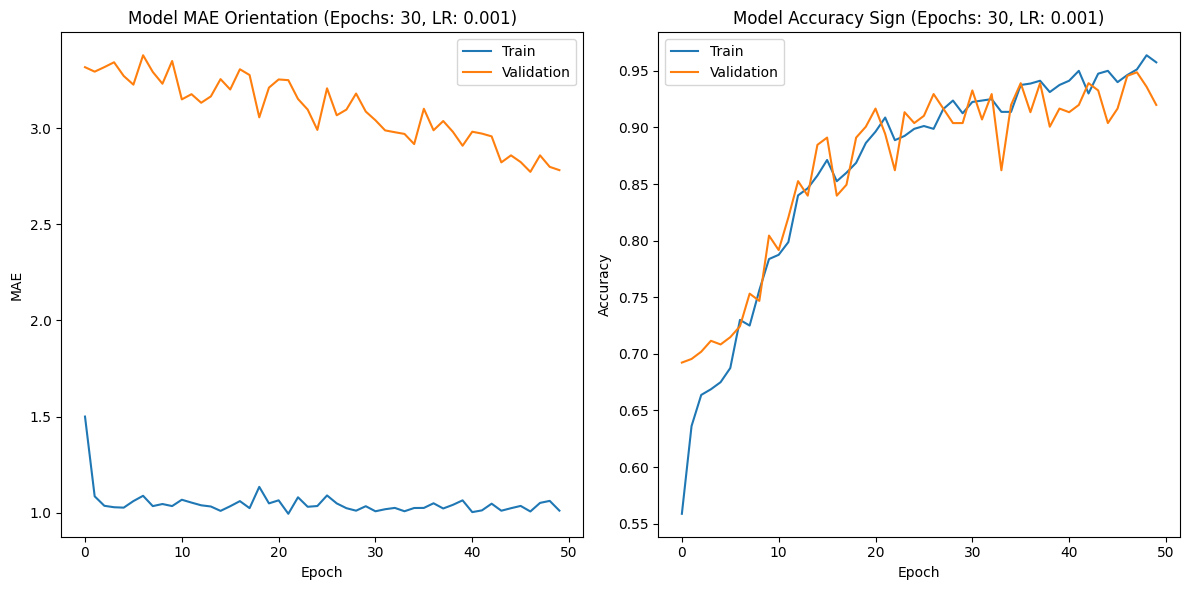

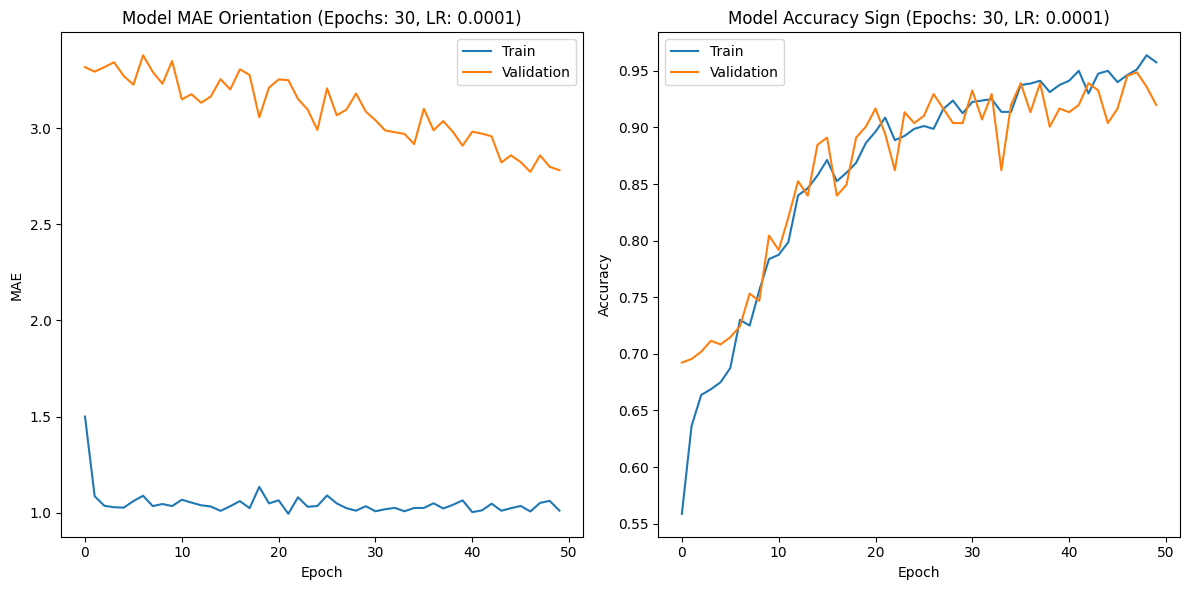

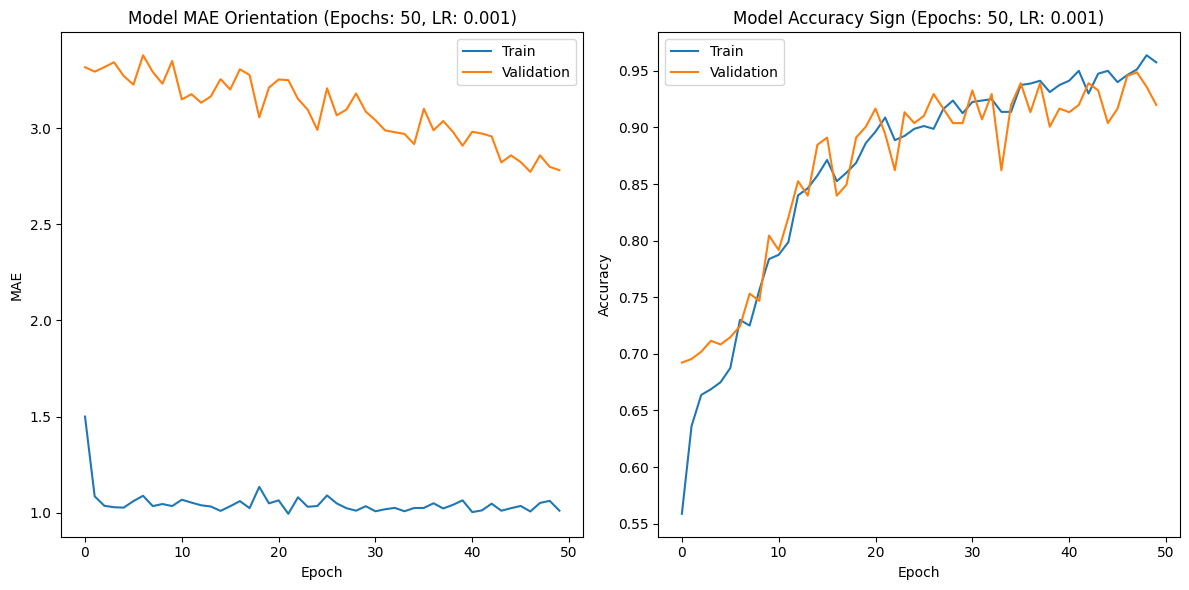

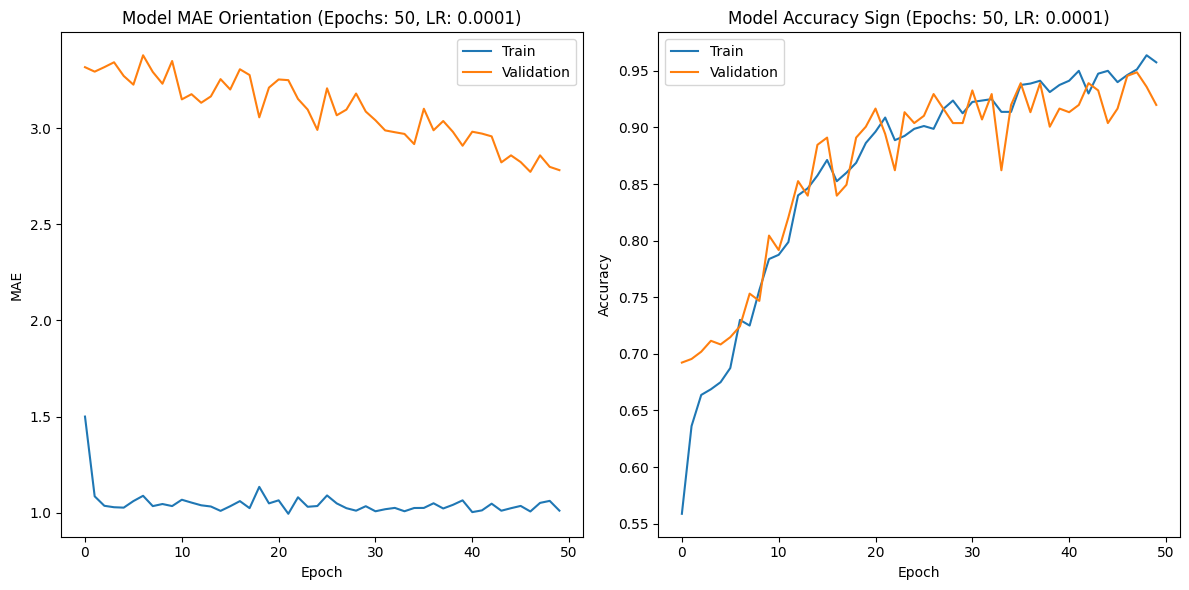

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Définir le modèle hybride
def build_model():
    input_layer = keras.layers.Input((228, 308, 3))
    x = tf.keras.layers.Rescaling(1./255)(input_layer)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    orientation_output = tf.keras.layers.Dense(1, name='orientation')(x)  # Activation linéaire par défaut

    y = tf.keras.layers.Rescaling(1./255)(input_layer)
    y = tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Conv2D(64, 3, activation='relu')(y)
    y = tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Conv2D(32, 3, activation='relu')(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(32, activation='relu')(y)

    sign_output = tf.keras.layers.Dense(1, name='sign', activation='sigmoid')(y)

    model = tf.keras.Model(inputs=input_layer, outputs=[orientation_output, sign_output])
    return model

# Paramètres du modèle à tester
epochs_list = [10, 30, 50]
learning_rates = [1e-3, 1e-4]
batch_size = 16

# Liste pour stocker les résultats
results = []

# Itérer sur les hyperparamètres
for epochs in epochs_list:
    for learning_rate in learning_rates:
        # Créer le modèle hybride
        hybrid_model = build_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate)

        # Compiler le modèle hybride avec des fonctions de perte appropriées
        hybrid_model.compile(optimizer=optimizer,
                             loss={'orientation': tf.keras.losses.MeanSquaredError(),
                                   'sign': tf.keras.losses.BinaryCrossentropy()},
                             metrics={'orientation': 'mae', 'sign': 'accuracy'})

        # Entraîner le modèle
        history = hybrid_model.fit(Xtrain, {'orientation': Ytrain_orientation, 'sign': Ytrain_sign},
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(Xtest, {'orientation': Ytest_orientation, 'sign': Ytest_sign}))

        # Évaluer le modèle hybride
        score_hybrid_model = hybrid_model.evaluate(Xtest, {'orientation': Ytest_orientation, 'sign': Ytest_sign}, verbose=0)

        # Enregistrer les résultats
        results.append({
            'Epochs': epochs,
            'Learning Rate': learning_rate,
            'Orientation MAE Train': history.history['orientation_mae'][-1],
            'Orientation MAE Validation': history.history['val_orientation_mae'][-1],
            'Sign Accuracy Train': history.history['sign_accuracy'][-1],
            'Sign Accuracy Validation': history.history['val_sign_accuracy'][-1],
        })

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame(results)

# Sauvegarder le tableau dans un fichier CSV
results_df.to_csv('metrics_comparative.csv', index=False)
print("Tableau comparatif des métriques et hyperparamètres sauvegardé sous 'metrics_comparative.csv'.")

# Visualisation de l'évolution de l'entraînement pour chaque configuration
def plot_training_evolution(history, epochs, learning_rate):
    # Tracer MAE pour l'orientation
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['orientation_mae'], label='Train')
    plt.plot(history.history['val_orientation_mae'], label='Validation')
    plt.title(f'Model MAE Orientation (Epochs: {epochs}, LR: {learning_rate})')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()

    # Tracer Précision du signe
    plt.subplot(1, 2, 2)
    plt.plot(history.history['sign_accuracy'], label='Train')
    plt.plot(history.history['val_sign_accuracy'], label='Validation')
    plt.title(f'Model Accuracy Sign (Epochs: {epochs}, LR: {learning_rate})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Appeler la fonction pour visualiser l'évolution de l'entraînement pour chaque configuration
for result in results:
    epochs = result['Epochs']
    learning_rate = result['Learning Rate']
    plot_training_evolution(history, epochs, learning_rate)

# Sauvegarder le modèle
hybrid_model.save("hybrid_model.keras")
